In [3]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

import pandas as pd
import sys
import graphlab
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
sns.set_context({'figure.figsize': [12, 7]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
print 'startup script successful'

Populating the interactive namespace from numpy and matplotlib


startup script successful


In [98]:
startup_data=graphlab.SFrame.read_csv('overall_company_list.csv')

Finished parsing file /home/aragon/Dropbox/ML_study/ML_project/startups_explore/overall_company_list.csv

Parsing completed. Parsed 100 lines in 0.129231 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,str,str,str,int,str,str,str,str,str,float,str,str,str,str,float,str,str,str,str,str,float,float,float,str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/aragon/Dropbox/ML_study/ML_project/startups_explore/overall_company_list.csv

Parsing completed. Parsed 11625 lines in 0.10795 secs.

In [3]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation)

In [4]:
def normalize_tf_idf(x):
    norm_factor=sqrt(sum(array(x.values())**2))
    x.update((w,v/norm_factor) for w, v in x.items())
    return x

In [14]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert x[column_name].dtype() == dict, \
        'The chosen column must be dict type, representing sparse data.'
    # Create triples of (row_id, feature_id, count).
    # 1. Add a row number.
    x = x.add_row_number()
    # 2. Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])

    # Map words into integers using a OneHotEncoder feature transformation.
    f = graphlab.feature_engineering.OneHotEncoder(features=['feature'])
    # 1. Fit the transformer using the above data.
    f.fit(x)
    # 2. The transform takes 'feature' column and adds a new column 'feature_encoding'.
    x = f.transform(x)
    # 3. Get the feature mapping.
    mapping = f['feature_encoding']
    # 4. Get the feature id to use for each key.
    x['feature_id'] = x['encoded_features'].dict_keys().apply(lambda x: x[0])

    # Create numpy arrays that contain the data for the sparse matrix.
    i = np.array(x['id'])
    j = np.array(x['feature_id'])
    v = np.array(x['value'])
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1

    mat=np.zeros([width,height])
    for d in x:
        mat[d['id'],d['feature_id']]=d['value']
    mat[isnan(mat)]=0
    return mat, mapping

In [7]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [105]:
exclude_kw=['data','software','big','analytics','machine','learning','&','media']

In [106]:
startup_data['Categories_clean']=startup_data['Categories'].apply(remove_punctuation)
startup_data['Description_clean']=startup_data['Description'].apply(remove_punctuation)

In [107]:
startup_data['word_count']=graphlab.text_analytics.count_words(startup_data['Categories_clean'])
startup_data['word_count']=startup_data['word_count'].dict_trim_by_keys(exclude_kw, exclude=True)

In [108]:
startup_data['tf_idf_cat']=graphlab.text_analytics.tf_idf(startup_data['Categories_clean'])
startup_data['tf_idf_cat']=startup_data['tf_idf_cat'].dict_trim_by_keys(exclude_kw, exclude=True)
startup_data['tf_idf_des']=graphlab.text_analytics.tf_idf(startup_data['Description'])
startup_data['tf_idf_des']=startup_data['tf_idf_des'].dict_trim_by_keys(list(graphlab.text_analytics.stopwords())+exclude_kw, exclude=True)

In [109]:
startup_data['tf_idf_cat_norm']=startup_data['tf_idf_cat'].apply(normalize_tf_idf)
startup_data['tf_idf_des_norm']=startup_data['tf_idf_des'].apply(normalize_tf_idf)

# simple word count model

In [72]:
model = graphlab.kmeans.create(startup_data,features=['word_count'], num_clusters=6,max_iterations=100,verbose=False)

In [73]:
model.cluster_info

word_count,cluster_id,size,sum_squared_distance
"{'things':0.03571428571428572, ...",0,252,835.788027525
"{'semantic':0.014697569248162843, ...",1,1769,6106.21148026
"{'spirits':0.008540372670807459, ...",2,1288,3962.25496706
"{'semantic':0.007635746606334834, ...",3,7072,20494.642362
"{'things':0.010457516339869298, ...",4,765,4030.49149507
"{'things':0.07724425887265132, ...",5,479,2005.01449704


In [75]:
for i in range(6):
    x=model.cluster_info[i]['word_count']
    x= sorted(x.items(), key=lambda x:x[1],reverse=True)[0:5]
    print [s[0] for s in x]

['security', 'cyber', 'mobile', 'network', 'management']
['intelligence', 'business', 'artificial', 'saas', 'mobile']
['services', 'based', 'location', 'mobile', 'social']
['mobile', 'research', 'market', 'saas', 'advertising']
['media', 'social', 'marketing', 'advertising', 'management']
['cloud', 'computing', 'services', 'saas', 'enterprise']


# TF-IDF model

In [76]:
model_2 = graphlab.kmeans.create(startup_data,features=['tf_idf_cat_norm'], num_clusters=6,max_iterations=100,verbose=False)
dis=model_2.cluster_info['sum_squared_distance'].sum()
min_cluster_size=model_2.cluster_info['size'].min()
while min_cluster_size<600: 
    model_2 = graphlab.kmeans.create(startup_data,features=['tf_idf_cat_norm'], num_clusters=6,max_iterations=100,verbose=False)
    dis=model_2.cluster_info['sum_squared_distance'].sum()
    min_cluster_size=model_2.cluster_info['size'].min()
    print dis,min_cluster_size
print model_2.cluster_info

9274.37121949 76
9470.59650514 163
8571.23315208 151
9534.06697348 92
9390.45659713 268
7378.33998146 183
10031.283457 59
8232.68377355 153
8722.54139953 606
+-------------------------------+------------+------+----------------------+
|        tf_idf_cat_norm        | cluster_id | size | sum_squared_distance |
+-------------------------------+------------+------+----------------------+
| {'semantic': 0.00530633527... |     0      | 6766 |    5452.59138851     |
| {'spirits': 0.002843393533... |     1      | 1220 |    757.297337234     |
| {'things': 0.0101712084220... |     2      | 1487 |    1099.52462125     |
| {'emerging': 0.00081943261... |     3      | 730  |    381.137725711     |
| {'things': 0.0124406972691... |     4      | 606  |    376.355108678     |
| {'things': 0.0119191408807... |     5      | 816  |    655.635218143     |
+-------------------------------+------------+------+----------------------+
[6 rows x 4 columns]



In [79]:
model_2.cluster_info

tf_idf_cat_norm,cluster_id,size,sum_squared_distance
"{'semantic':0.005306335270666281, ...",0,6766,5452.59138851
"{'spirits':0.002843393533918914, ...",1,1220,757.297337234
"{'things':0.010171208422037382, ...",2,1487,1099.52462125
"{'emerging':0.0008194326111316998, ...",3,730,381.137725711
"{'things':0.012440697269143194, ...",4,606,376.355108678
"{'things':0.011919140880747645, ...",5,816,655.635218143


In [80]:
for i in range(6):
    x=model_2.cluster_info[i]['tf_idf_cat_norm']
    x= sorted(x.items(), key=lambda x:x[1],reverse=True)[0:6]
    print [s[0] for s in x]

['mobile', 'advertising', 'media', 'saas', 'visualization', 'social']
['based', 'location', 'services', 'mobile', 'social', 'media']
['intelligence', 'business', 'artificial', 'saas', 'enterprise', 'predictive']
['market', 'research', 'media', 'social', 'mobile', 'consulting']
['information', 'technology', 'health', 'care', 'services', 'intelligence']
['enterprise', 'predictive', 'saas', 'visualization', 'cloud', 'marketing']


# TF-IDF with Description

In [14]:
model_3 = graphlab.kmeans.create(startup_data,features=['tf_idf_des_norm'], num_clusters=6,max_iterations=100,verbose=False)
dis=model_3.cluster_info['sum_squared_distance'].sum()
print dis
print model_3.cluster_info

9590.99886413
+-------------------------------+------------+------+----------------------+
|        tf_idf_des_norm        | cluster_id | size | sum_squared_distance |
+-------------------------------+------------+------+----------------------+
| {'paperless': 4.5388632765... |     0      | 8248 |    6766.50957234     |
| {'roi': 0.0017298890065280... |     1      | 178  |    158.797251344     |
| {'vod': 0.0012517813720060... |     2      | 501  |    443.648205578     |
| {'encored': 0.000224477910... |     3      | 2106 |    1724.60187685     |
| {'shop': 0.001161760185428... |     4      | 239  |    200.338272214     |
| {'internet.': 0.0032342997... |     5      | 353  |    297.103685796     |
+-------------------------------+------------+------+----------------------+
[6 rows x 4 columns]



In [15]:
for i in range(6):
    x=model_3.cluster_info[i]['tf_idf_des_norm']
    x= sorted(x.items(), key=lambda x:x[1],reverse=True)[0:6]
    print [s[0] for s in x]

['mobile', 'platform', 'technology', 'software', 'social', 'company']
['brands', 'social', 'marketing', 'understand', 'helps', 'agencies']
['marketing', 'digital', 'platform', '&', 'analytics', 'automation']
['data', 'analytics', 'big', 'intelligence', 'platform', 'business']
['content', 'publishers', 'platform', 'social', 'digital', 'web']
['create', 'share', 'users', 'enables', 'experiences', 'mobile']


# Use Sk-learn to check

9305.13954002
['saas' 'mobile' 'advertising' 'social' 'visualization']
['intelligence' 'business' 'artificial' 'saas' 'enterprise']
['based' 'location' 'services' 'mobile' 'social']
['market' 'research' 'social' 'mobile' 'consulting']
['internet' 'things' 'of' 'mobile' 'saas']
['information' 'technology' 'health' 'care' 'intelligence']


(array([ 6953.,     0.,  1412.,     0.,  1200.,     0.,   749.,     0.,
          485.,   826.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

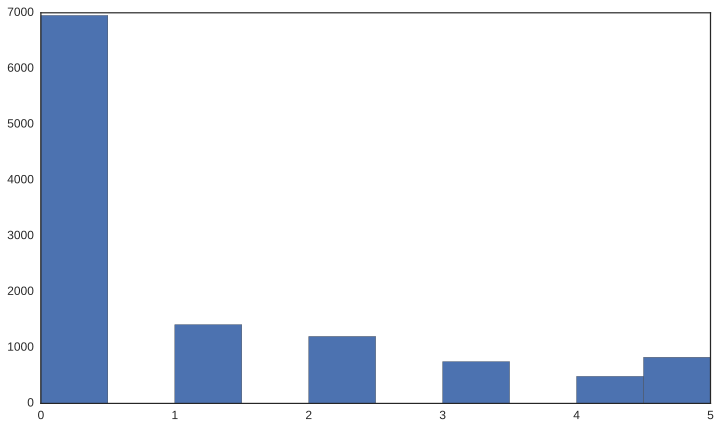

In [113]:
x,mapping=sframe_to_scipy(startup_data,'tf_idf_cat')
x_n=sk.preprocessing.normalize(x)
k=6
kmeans_model=KMeans(n_clusters=k,n_init=50,n_jobs=-1)
kmeans_model.fit(x_n)
centroids, cluster_assignment = kmeans_model.cluster_centers_, kmeans_model.labels_
print compute_heterogeneity(x_n,k,centroids,cluster_assignment)
for i in range(k):
    x=centroids[i]
    print mapping['category'].to_numpy()[argsort(x)[::-1][0:5]]
hist(cluster_assignment)

In [114]:
for i in range(k):
    x=centroids[i]
    print mapping['category'].to_numpy()[argsort(x)[::-1][0:10]]

['saas' 'mobile' 'advertising' 'social' 'visualization' 'enterprise'
 'ecommerce' 'marketing' 'predictive' 'cloud']
['intelligence' 'business' 'artificial' 'saas' 'enterprise' 'predictive'
 'visualization' 'mobile' 'development' 'ecommerce']
['based' 'location' 'services' 'mobile' 'social' 'apps' 'local' 'ios'
 'travel' 'events']
['market' 'research' 'social' 'mobile' 'consulting' 'saas' 'service'
 'advertising' 'business' 'customer']
['internet' 'things' 'of' 'mobile' 'saas' 'hardware' 'cloud' 'artificial'
 'intelligence' 'electronics']
['information' 'technology' 'health' 'care' 'intelligence' 'services'
 'medical' 'mhealth' 'predictive' 'artificial']


In [115]:
cluster_assignment.shape

(11625,)

In [116]:
savetxt('cluster_assignment.txt',cluster_assignment,fmt='%d')
savetxt('centroids.txt',centroids)
mapping.save('word_mapping')

In [4]:
startup_data=graphlab.SFrame('startup_data')

This non-commercial license of GraphLab Create for academic use is assigned to aragonly@uw.edu and will expire on August 17, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1476264442.log


In [132]:
def render_centroid(cent,mapping):
    idx_sort=argsort(cent)[::-1]
    for i in range(10):
        for j in range(int(1000*cent[idx_sort[i]])):
            print mapping['category'].to_numpy()[idx_sort[i]],

In [2]:
hist(cluster_assignment)

In [151]:
startup_data['cluster_id']=cluster_assignment

In [5]:
df=startup_data.to_dataframe()

In [8]:
df1=df[['cluster_id','year','Total Funding Amount']]

In [10]:
df1['funding']=df1['Total Funding Amount'].str.translate(None,'$,').convert_objects(convert_numeric=True)

/home/aragon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':
/home/aragon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


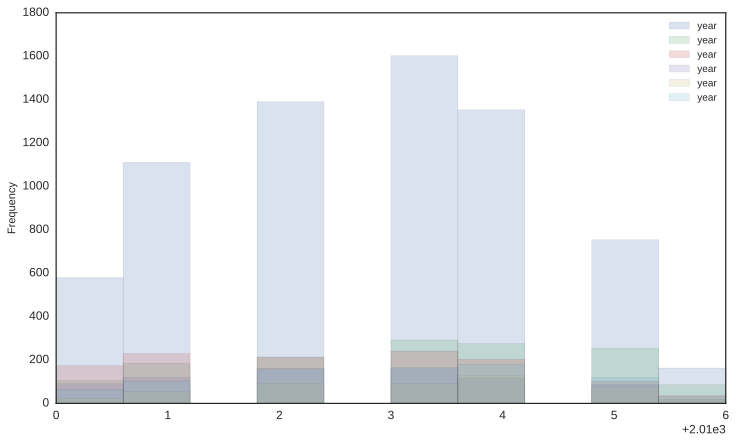

In [30]:
fig, ax = subplots()
for key,grp in df1.groupby('cluster_id'):
    grp.plot(y='year',kind='hist',ax=ax,alpha=0.2,stacked=True)

In [33]:
df1.groupby(['year','cluster_id']).describe().unstack()

funding                                                    \
                    count          mean           std       min 25% 50% 75%   
year   cluster_id                                                             
2010.0 0            266.0  1.508443e+07  4.258199e+07    1000.0 NaN NaN NaN   
       1             49.0  2.951401e+07  9.180599e+07   20118.0 NaN NaN NaN   
       2             60.0  4.200788e+06  1.022961e+07   15000.0 NaN NaN NaN   
       3             25.0  6.352907e+06  1.091290e+07   25000.0 NaN NaN NaN   
       4             10.0  7.393306e+06  1.128840e+07  122000.0 NaN NaN NaN   
       5             40.0  3.195659e+07  9.191265e+07   10000.0 NaN NaN NaN   
2011.0 0            534.0  1.053130e+07  3.226542e+07    3000.0 NaN NaN NaN   
       1             94.0  9.363149e+06  1.620559e+07   45000.0 NaN NaN NaN   
       2             72.0  6.878909e+06  2.092100e+07   12500.0 NaN NaN NaN   
       3             35.0  4.568347e+06  6.302902e+06   50000.0 NaN NaN NaN   
       4             40.0  6.892876e+06  1.283903e+07   81551.0 NaN NaN NaN   
       5             55.0  8.778257e+06  8.649975e+06   30000.0 NaN NaN NaN   
2012.0 0            676.0  1.073695e+07  3.678935e+07    3500.0 NaN NaN NaN   
       1            106.0  1.001661e+07  2.606426e+07   10000.0 NaN NaN NaN   
       2             70.0  4.425569e+06  1.067325e+07    9203.0 NaN NaN NaN   
       3             48.0  4.909812e+06  1.110328e+07   20000.0 NaN NaN NaN   
       4             61.0  1.078970e+07  1.581057e+07   35000.0 NaN NaN NaN   
       5            104.0  1.272433e+07  1.835537e+07   20000.0 NaN NaN NaN   
2013.0 0            749.0  6.958986e+06  6.295134e+07    9000.0 NaN NaN NaN   
       1            120.0  5.299783e+06  1.084836e+07   10000.0 NaN NaN NaN   
       2             92.0  2.626591e+06  5.714862e+06   15000.0 NaN NaN NaN   
       3             51.0  5.920179e+06  1.244087e+07   12000.0 NaN NaN NaN   
       4             50.0  5.969281e+06  1.733479e+07   21145.0 NaN NaN NaN   
       5             86.0  6.742387e+06  1.794580e+07    7500.0 NaN NaN NaN   
2014.0 0            575.0  3.417623e+06  9.045633e+06    4000.0 NaN NaN NaN   
       1            106.0  4.693865e+06  1.435635e+07   10000.0 NaN NaN NaN   
       2             67.0  8.837901e+05  1.340060e+06   10000.0 NaN NaN NaN   
       3             31.0  3.332368e+06  6.043419e+06    7500.0 NaN NaN NaN   
       4             60.0  4.728310e+06  1.253604e+07    3536.0 NaN NaN NaN   
       5             88.0  7.883738e+06  1.312384e+07   16450.0 NaN NaN NaN   
2015.0 0            298.0  1.991046e+06  4.702185e+06   10000.0 NaN NaN NaN   
       1             96.0  2.081612e+06  5.988269e+06    7500.0 NaN NaN NaN   
       2             31.0  4.957000e+05  9.883399e+05    5000.0 NaN NaN NaN   
       3             26.0  9.673603e+05  1.523950e+06    5000.0 NaN NaN NaN   
       4             35.0  2.010090e+06  3.742532e+06   20000.0 NaN NaN NaN   
       5             60.0  7.202524e+06  2.864196e+07    2129.0 NaN NaN NaN   
2016.0 0             34.0  7.007876e+05  1.005696e+06   10000.0 NaN NaN NaN   
       1             29.0  6.922399e+05  9.385823e+05   16979.0 NaN NaN NaN   
       2              3.0  2.179350e+05  2.480482e+05   33805.0 NaN NaN NaN   
       3              3.0  5.580000e+06  9.630202e+06   20000.0 NaN NaN NaN   
       4              3.0  6.679327e+05  1.113592e+06   25000.0 NaN NaN NaN   
       5              8.0  8.336027e+06  1.342828e+07   61217.0 NaN NaN NaN   

                                 
                            max  
year   cluster_id                
2010.0 0           5.220000e+08  
       1           5.896500e+08  
       2           5.195000e+07  
       3           4.362000e+07  
       4           3.550000e+07  
       5           5.700000e+08  
2011.0 0           5.787000e+08  
       1           9.600000e+07  
       2           1.025000e+08  
       3           2.596251e+07  
       4           5